In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from random import randint
import numpy as np
import torch
import time
import torch.nn as nn

In [2]:
# !mkdir GloVe
# !curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip GloVe/glove.840B.300d.zip -d GloVe/
# !mkdir fastText
# !curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
# !unzip fastText/crawl-300d-2M.vec.zip -d fastText/

In [3]:
# !mkdir encoder
# !curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
# !curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/rehan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [72]:
class InferSent(nn.Module):

    def __init__(self, config):
        super(InferSent, self).__init__()
        self.bsize = config['bsize']
        self.word_emb_dim = config['word_emb_dim']
        self.enc_lstm_dim = config['enc_lstm_dim']
        self.pool_type = config['pool_type']
        self.dpout_model = config['dpout_model']
        self.version = 1 if 'version' not in config else config['version']

        self.enc_lstm = nn.LSTM(self.word_emb_dim, self.enc_lstm_dim, 1,
                                bidirectional=True, dropout=self.dpout_model)

        assert self.version in [1, 2]
        if self.version == 1:
            self.bos = '<s>'
            self.eos = '</s>'
            self.max_pad = True
            self.moses_tok = False
        elif self.version == 2:
            self.bos = '<p>'
            self.eos = '</p>'
            self.max_pad = False
            self.moses_tok = True

    def is_cuda(self):
        # either all weights are on cpu or they are on gpu
        return self.enc_lstm.bias_hh_l0.data.is_cuda

    def forward(self, sent_tuple):
        # sent_len: [max_len, ..., min_len] (bsize)
        # sent: (seqlen x bsize x worddim)
        sent, sent_len = sent_tuple

        # Sort by length (keep idx)
        sent_len_sorted, idx_sort = np.sort(sent_len)[::-1], np.argsort(-sent_len)
        sent_len_sorted = sent_len_sorted.copy()
        idx_unsort = np.argsort(idx_sort)

        idx_sort = torch.from_numpy(idx_sort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_sort)
        sent = sent.index_select(1, idx_sort)

        # Handling padding in Recurrent Networks
        sent_packed = nn.utils.rnn.pack_padded_sequence(sent, sent_len_sorted)
        sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid
        sent_output = nn.utils.rnn.pad_packed_sequence(sent_output)[0]

        # Un-sort by length
        idx_unsort = torch.from_numpy(idx_unsort).cuda() if self.is_cuda() \
            else torch.from_numpy(idx_unsort)
        sent_output = sent_output.index_select(1, idx_unsort)

        # Pooling
        if self.pool_type == "mean":
            sent_len = torch.FloatTensor(sent_len.copy()).unsqueeze(1).cuda()
            emb = torch.sum(sent_output, 0).squeeze(0)
            emb = emb / sent_len.expand_as(emb)
        elif self.pool_type == "max":
            if not self.max_pad:
                sent_output[sent_output == 0] = -1e9
            emb = torch.max(sent_output, 0)[0]
            if emb.ndimension() == 3:
                emb = emb.squeeze(0)
                assert emb.ndimension() == 2

        return emb

    def set_w2v_path(self, w2v_path):
        self.w2v_path = w2v_path

    def get_word_dict(self, sentences, tokenize=True):
        # create vocab of words
        word_dict = {}
        sentences = [s.split() if not tokenize else self.tokenize(s) for s in sentences]
        for sent in sentences:
            for word in sent:
                if word not in word_dict:
                    word_dict[word] = ''
        word_dict[self.bos] = ''
        word_dict[self.eos] = ''
        return word_dict

    def get_w2v(self, word_dict):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with w2v vectors
        word_vec = {}
        with open(self.w2v_path) as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if word in word_dict:
                    word_vec[word] = np.fromstring(vec, sep=' ')
        print('Found %s(/%s) words with w2v vectors' % (len(word_vec), len(word_dict)))
        return word_vec

    def get_w2v_k(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        # create word_vec with k first w2v vectors
        k = 0
        word_vec = {}
        with open(self.w2v_path) as f:
            for line in f:
                word, vec = line.split(' ', 1)
                if k <= K:
                    word_vec[word] = np.fromstring(vec, sep=' ')
                    k += 1
                if k > K:
                    if word in [self.bos, self.eos]:
                        word_vec[word] = np.fromstring(vec, sep=' ')

                if k > K and all([w in word_vec for w in [self.bos, self.eos]]):
                    break
        return word_vec

    def build_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        word_dict = self.get_word_dict(sentences, tokenize)
        self.word_vec = self.get_w2v(word_dict)
        print('Vocab size : %s' % (len(self.word_vec)))

    # build w2v vocab with k most frequent words
    def build_vocab_k_words(self, K):
        assert hasattr(self, 'w2v_path'), 'w2v path not set'
        self.word_vec = self.get_w2v_k(K)
        print('Vocab size : %s' % (K))

    def update_vocab(self, sentences, tokenize=True):
        assert hasattr(self, 'w2v_path'), 'warning : w2v path not set'
        assert hasattr(self, 'word_vec'), 'build_vocab before updating it'
        word_dict = self.get_word_dict(sentences, tokenize)

        # keep only new words
        for word in self.word_vec:
            if word in word_dict:
                del word_dict[word]

        # udpate vocabulary
        if word_dict:
            new_word_vec = self.get_w2v(word_dict)
            self.word_vec.update(new_word_vec)
        else:
            new_word_vec = []
        print('New vocab size : %s (added %s words)'% (len(self.word_vec), len(new_word_vec)))

    def get_batch(self, batch):
        # sent in batch in decreasing order of lengths
        # batch: (bsize, max_len, word_dim)
        embed = np.zeros((len(batch[0]), len(batch), self.word_emb_dim))

        for i in range(len(batch)):
            for j in range(len(batch[i])):
                embed[j, i, :] = self.word_vec[batch[i][j]]

        return torch.FloatTensor(embed)

    def tokenize(self, s):
        from nltk.tokenize import word_tokenize
        if self.moses_tok:
            s = ' '.join(word_tokenize(s))
            s = s.replace(" n't ", "n 't ")  # HACK to get ~MOSES tokenization
            return s.split()
        else:
            return word_tokenize(s)

    def prepare_samples(self, sentences, bsize, tokenize, verbose):
        sentences = [[self.bos] + s.split() + [self.eos] if not tokenize else
                     [self.bos] + self.tokenize(s) + [self.eos] for s in sentences]
        n_w = np.sum([len(x) for x in sentences])

        # filters words without w2v vectors
        for i in range(len(sentences)):
            s_f = [word for word in sentences[i] if word in self.word_vec]
            if not s_f:
                import warnings
                warnings.warn('No words in "%s" (idx=%s) have w2v vectors. \
                               Replacing by "</s>"..' % (sentences[i], i))
                s_f = [self.eos]
            sentences[i] = s_f

        lengths = np.array([len(s) for s in sentences])
        n_wk = np.sum(lengths)
        if verbose:
            print('Nb words kept : %s/%s (%.1f%s)' % (
                        n_wk, n_w, 100.0 * n_wk / n_w, '%'))

        # sort by decreasing length
        lengths, idx_sort = np.sort(lengths)[::-1], np.argsort(-lengths)
        sentences = np.array(sentences)[idx_sort]

        return sentences, lengths, idx_sort

    def encode(self, sentences, bsize=64, tokenize=True, verbose=False):
        tic = time.time()
        sentences, lengths, idx_sort = self.prepare_samples(
                        sentences, bsize, tokenize, verbose)

        embeddings = []
        for stidx in range(0, len(sentences), bsize):
            batch = self.get_batch(sentences[stidx:stidx + bsize])
            if self.is_cuda():
                batch = batch.cuda()
            with torch.no_grad():
                batch = self.forward((batch, lengths[stidx:stidx + bsize])).data.cpu().numpy()
            embeddings.append(batch)
        embeddings = np.vstack(embeddings)

        # unsort
        idx_unsort = np.argsort(idx_sort)
        embeddings = embeddings[idx_unsort]

        if verbose:
            print('Speed : %.1f sentences/s (%s mode, bsize=%s)' % (
                    len(embeddings)/(time.time()-tic),
                    'gpu' if self.is_cuda() else 'cpu', bsize))
        return embeddings

    def visualize(self, sent, tokenize=True):

        sent = sent.split() if not tokenize else self.tokenize(sent)
        sent = [[self.bos] + [word for word in sent if word in self.word_vec] + [self.eos]]

        if ' '.join(sent[0]) == '%s %s' % (self.bos, self.eos):
            import warnings
            warnings.warn('No words in "%s" have w2v vectors. Replacing \
                           by "%s %s"..' % (sent, self.bos, self.eos))
        batch = self.get_batch(sent)

        if self.is_cuda():
            batch = batch.cuda()
        output = self.enc_lstm(batch)[0]
        output, idxs = torch.max(output, 0)
        # output, idxs = output.squeeze(), idxs.squeeze()
        idxs = idxs.data.cpu().numpy()
        argmaxs = [np.sum((idxs == k)) for k in range(len(sent[0]))]

        # visualize model
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12,12))
        x = range(len(sent[0]))
        y = [100.0 * n / np.sum(argmaxs) for n in argmaxs]
        plt.xticks(x, sent[0], rotation=45)
        plt.bar(x, y)
        plt.ylabel('%')
        plt.title('Visualisation of words importance')
        plt.show()

        return output, idxs, argmaxs


In [73]:
model_version = 2
MODEL_PATH = "encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}

In [74]:
model = InferSent(params_model)

In [75]:
model.load_state_dict(torch.load(MODEL_PATH))

In [76]:
use_cuda = False
model = model.cuda() if use_cuda else model

In [77]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [78]:
# Load embeddings of K most frequent words
model.build_vocab_k_words(K=100000)

Vocab size : 100000


In [79]:
# Load some sentences
sentences = []
with open('samples.txt') as f:
    for line in f:
        sentences.append(line.strip())
print(len(sentences))

9815


In [80]:
embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 127563/130068 (98.1%)
Speed : 48.0 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 9815


In [81]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [82]:
text1 = "everyone hate you"
text2 = "people despise you"

In [83]:
cosine(model.encode([text1])[0], model.encode([text2])[0])

0.86680156

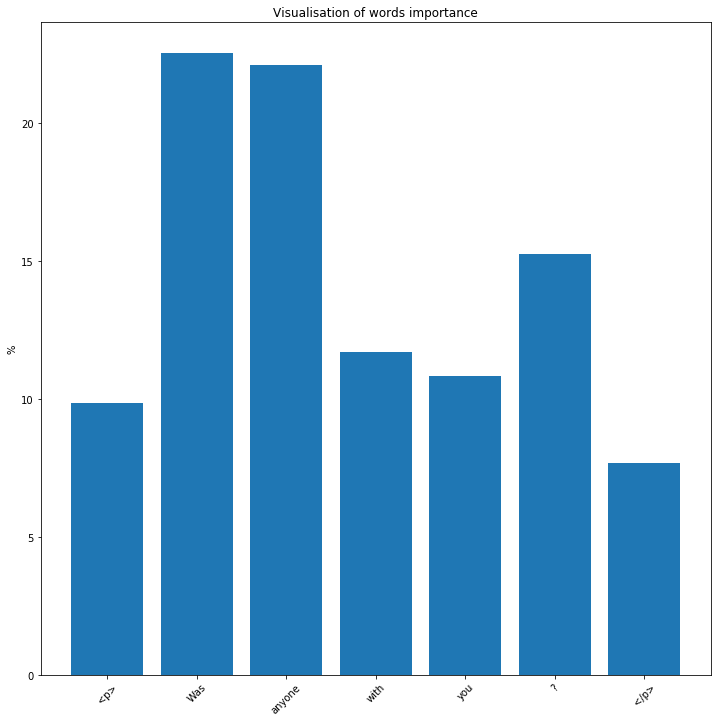

ValueError: too many values to unpack (expected 2)

In [84]:
idx = randint(0, len(sentences))
_, _ = model.visualize(sentences[idx])